In [162]:
EPOCHS = 2
PS = 256
HEIGHT = 1424
WIDTH = 2128
BATCHSIZE = 32
LEARNING_RATE = 1e-3
NUMBER_OF_CROPS = 4

In [163]:
#IMPORTS:
import os
import skimage.io as io
import skimage.transform as trans

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import rawpy
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.layers import Lambda
import tensorflow as tf

import time

In [164]:
trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
replaceString = "/home/takats_balint1/deephf/data"

In [165]:
trainData = []
with open(trainPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        trainData.append([data, truth])
print (len(trainData))

1865


In [166]:
valData = []
with open(valPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        # If we had much more data we would consider reserveing the memory first.
        valData.append([data, truth])
print (len(valData))

234


In [167]:
testData = []
with open(testPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        testData.append([data, truth])
print (len(testData))

598


In [168]:
def unet(input_size = (PS, PS, 4)):
    inputs = Input(input_size)
    # s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) # (s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
    c10 = Conv2D(12, (1, 1))(c9)
    depthToSpace = Lambda(lambda x:tf.nn.depth_to_space(x,2))
    outputs = depthToSpace(c10)
 
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return model


In [169]:
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - PS, 0) / (16383 - PS)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]
    
    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

In [170]:
from tensorflow.keras.callbacks import Callback
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
     
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

patience = 4
early_stopping = EarlyStopping(patience=patience, verbose=1)

checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

In [171]:
Model = unet()
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
Model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

In [172]:
# Lásd https://keras.io/guides/writing_a_training_loop_from_scratch/
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = Model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, Model.trainable_weights)
    optimizer.apply_gradients(zip(grads, Model.trainable_weights))
    # train_acc_metric.update_state(y, logits)
    return loss_value

In [173]:
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    
    trainPermutation = np.random.permutation(len(trainData[:256]))
    
    for j in range(len(trainPermutation)//BATCHSIZE):
        trainBatch = [None]*BATCHSIZE
        truthBatch = [None]*BATCHSIZE
        start_time = time.time()
        for k in range(BATCHSIZE//NUMBER_OF_CROPS):
            trainPath = trainData[trainPermutation[j]][0]
            truthPath = trainData[trainPermutation[j]][1]
        
            raw = rawpy.imread(trainPath)
            raw = np.expand_dims(pack_raw(raw), axis=0)
        
            gt_raw = rawpy.imread(truthPath)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_image = np.expand_dims(np.float32(im / 65535.0), axis=0)
            for crop in range(NUMBER_OF_CROPS):
                xx = np.random.randint(0, WIDTH - PS)
                yy = np.random.randint(0, HEIGHT - PS)
                input_patch = raw[:, yy:yy + PS, xx:xx + PS, :]
                gt_patch = gt_image[:, yy * 2:yy * 2 + PS * 2, xx * 2:xx * 2 + PS * 2, :]
        
                input_patch = np.minimum(input_patch, 1.0)
                trainBatch[k*NUMBER_OF_CROPS+crop] = input_patch
                truthBatch[k*NUMBER_OF_CROPS+crop] = gt_patch
        load_end_time = time.time()
        # Ez ilyen szarul jó mert így gyors lást https://keras.io/guides/writing_a_training_loop_from_scratch/
        loss_value = train_step(trainBatch, truthBatch)
        end_time = time.time()
        print("\nEnd of batch %d" % (j,))
        print("Time taken: " + str(end_time-start_time))
        print("Load time taken: " + str(load_end_time-start_time))
        print("Loss is at: " + str(loss_value))
        
        # Model.fit(input_patch, gt_patch)
        trainOut = Model.train_on_batch(input_patch, gt_patch)
        print("Loss: {}".format(round(trainOut[0], 4)))
        print("Accuracy: {}".format(round(trainOut[1], 4)))
        


Start of epoch 0

End of batch 0
Time taken: 16.589590311050415
Load time taken: 13.345279455184937
Loss is at: tf.Tensor(1.6199365, shape=(), dtype=float32)
1/1 [==============================] - 0s 26ms/step - loss: 1.3823 - accuracy: 0.3416

End of batch 1
Time taken: 13.874499559402466
Load time taken: 13.791476488113403
Loss is at: tf.Tensor(1.132551, shape=(), dtype=float32)
1/1 [==============================] - 0s 23ms/step - loss: 0.9538 - accuracy: 0.3707

End of batch 2
Time taken: 13.77003288269043
Load time taken: 13.694616317749023
Loss is at: tf.Tensor(0.77045804, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step - loss: 0.6895 - accuracy: 0.3861

End of batch 3
Time taken: 13.728346347808838
Load time taken: 13.645325899124146
Loss is at: tf.Tensor(0.4964685, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step - loss: 0.4180 - accuracy: 0.4348

End of batch 4
Time taken: 13.73242449760437
Load time taken: 13.656644821

In [ ]:
raw = rawpy.imread(testData[30][0])
raw = np.expand_dims(pack_raw(raw), axis=0)

input_patch = np.minimum(raw, 1.0)

test_out = Model.predict(raw)
test_out =  test_out*255.55
test_out = np.minimum(np.maximum(0, test_out),255)

In [86]:
print(test_out.shape)
test_out = test_out.reshape(test_out.shape[1], test_out.shape[2], test_out.shape[3])
print(test_out.shape)

(1, 2848, 4256, 3)
(2848, 4256, 3)


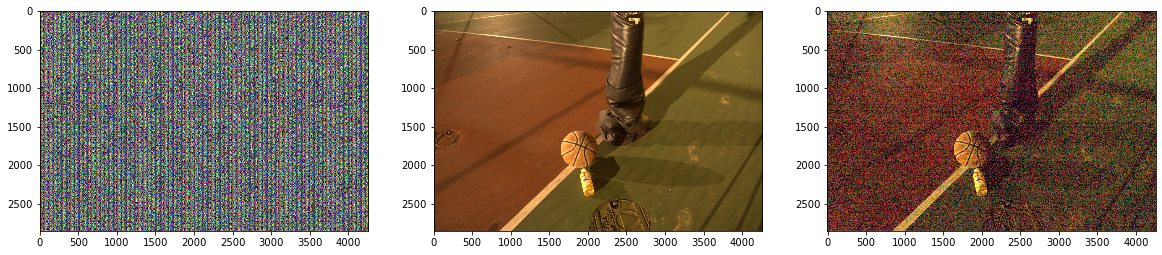

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from matplotlib import cm

test_truth = rawpy.imread(testData[30][1])
test_truth = test_truth.postprocess()

test_ori = rawpy.imread(testData[30][0])
test_ori = test_ori.postprocess()

#test_out[100, 100] = [255, 0, 0]
img = Image.fromarray(test_out, 'RGB')

fig, axes = plt.subplots(1,3, figsize=(20,20))
axes[0].imshow(img, interpolation='nearest')
axes[1].imshow(test_truth, interpolation='nearest')
axes[2].imshow(test_ori, interpolation='nearest')
plt.show()

In [ ]:
model = unet2()
for index in range(len(trainData[:20])): 
    raw_input = trainData[index][0] #input
    groundtruth_raw = trainData[index][1] #output    
    
    raw_input_val = valData[index][0]
    groundtruth_raw_val = valData[index][1]
    
    raw = rawpy.imread(raw_input)
    raw = np.expand_dims(pack_raw(raw), axis=0)
    
    raw_val = rawpy.imread(raw_input_val)
    raw_val = np.expand_dims(pack_raw(raw_val), axis=0)
    
    gt_raw = rawpy.imread(groundtruth_raw)
    # gt_raw = gt_raw.postprocess()
    # gt_raw = np.expand_dims(gt_raw, axis=0)
    gt_raw = np.expand_dims(pack_raw2(gt_raw), axis=0)
    # gt.raw = np.concatenate()
    
    gt_raw_val = rawpy.imread(groundtruth_raw_val)
    # gt_raw_val = gt_raw_val.postprocess()
    # gt_raw_val = np.expand_dims(gt_raw_val, axis=0)
    gt_raw_val = np.expand_dims(pack_raw2(gt_raw_val), axis=0)
    
    
    #print(raw.shape)
    #print(gt_raw.shape)
    
    # crop
    H = raw.shape[1]
    W = raw.shape[2]

    xx = np.random.randint(0, W - PS)
    yy = np.random.randint(0, H - PS)
    
    input_patch = raw[:, yy:yy + PS, xx:xx + PS, :]
    gt_patch = gt_raw[:, yy:yy + PS, xx:xx + PS, :]
    
    input_patch_val = raw_val[:, yy:yy + PS, xx:xx + PS, :]
    gt_patch_val = gt_raw_val[:, yy:yy + PS, xx:xx + PS, :]
    
    input_patch = np.minimum(input_patch, 1.0)
    input_patch_val = np.minimum(input_patch_val, 1.0)
    
    # print(input_patch)
    # print(gt_patch)
    
    model.fit(input_patch, gt_patch, validation_data= (input_patch_val, gt_patch_val))
    # model.fit(raw, gt_raw, epochs = 2, validation_data=(raw_val, gt_raw_val))
              #callbacks = [reduce_lr, checkpointer, early_stopping, history], shuffle= True)

In [29]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


/home/takats_balint1/deephf/data/Sony/short/00001_00_0.04s.ARW


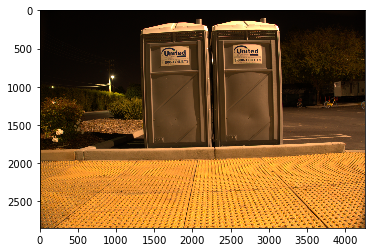

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(1):
    raw = rawpy.imread(trainData[i][0])
    print(trainData[i][0])
    dataInputScaled = raw.postprocess()
    plt.imshow(dataInputScaled, interpolation='nearest')
    plt.show()

In [51]:
for i in range(100):
    print(trainData[i])

['/home/takats_balint1/deephf/data/Sony/short/00001_00_0.04s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_00_0.1s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_01_0.04s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_01_0.1s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_02_0.1s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_03_0.1s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_04_0.1s.ARW', '/home/takats_balint1/deephf/data/Sony/long/00001_00_10s.ARW']
['/home/takats_balint1/deephf/data/Sony/short/00001_05_0.1s.ARW', '/home/takats_balint1/deephf/

In [12]:
# uniform content loss + adaptive threshold + per_class_input + recursive G
# improvement upon cqf37
from __future__ import division
import os, time, scipy.io
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
# import tensorflow.contrib.slim as slim
import numpy as np
import rawpy
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
# testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
# valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
# replaceString = "/home/takats_balint1/deephf/data"

input_dir = '/home/takats_balint1/deephf/data/Sony/short/'
gt_dir = '/home/takats_balint1/deephf/data/Sony/long/'
checkpoint_dir = '/home/takats_balint1/deephf/result_Sony/'
result_dir = '/home/takats_balint1/deephf/result_Sony/'

# get train IDs
train_fns = glob.glob(gt_dir + '0*.ARW')
train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]

ps = 512  # patch size for training
save_freq = 500

DEBUG = 0
if DEBUG == 1:
    save_freq = 2
    train_ids = train_ids[0:5]


def lrelu(x):
    return tf.maximum(x * 0.2, x)


def upsample_and_concat(x1, x2, output_channels, in_channels):
    pool_size = 2
    deconv_filter = tf.Variable(tf.truncated_normal([pool_size, pool_size, output_channels, in_channels], stddev=0.02))
    deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2), strides=[1, pool_size, pool_size, 1])

    deconv_output = tf.concat([deconv, x2], 3)
    deconv_output.set_shape([None, None, None, output_channels * 2])

    return deconv_output


def network(input_size = (512, 512, 4)):
    inputs = Input(input_size)
    # s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) # (s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c9)
 
    return outputs


def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out


sess = tf.Session()
in_image = tf.placeholder(tf.float32, [None, None, None, 4])
gt_image = tf.placeholder(tf.float32, [None, None, None, 3])
out_image = network()

G_loss = tf.reduce_mean(tf.abs(out_image - gt_image))

t_vars = tf.trainable_variables()
lr = tf.placeholder(tf.float32)
G_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded ' + ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

# Raw data takes long time to load. Keep them in memory after loaded.
gt_images = [None] * 6000
input_images = {}
input_images['300'] = [None] * len(train_ids)
input_images['250'] = [None] * len(train_ids)
input_images['100'] = [None] * len(train_ids)

g_loss = np.zeros((5000, 1))

allfolders = glob.glob(result_dir + '*0')
lastepoch = 0
for folder in allfolders:
    lastepoch = np.maximum(lastepoch, int(folder[-4:]))

learning_rate = 1e-4
for epoch in range(lastepoch, 4001):
    if os.path.isdir(result_dir + '%04d' % epoch):
        continue
    cnt = 0
    if epoch > 2000:
        learning_rate = 1e-5

    for ind in np.random.permutation(len(train_ids)):
        # get the path from image id
        train_id = train_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()
        cnt += 1

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))

        input_patch = np.minimum(input_patch, 1.0)

        _, G_current, output = sess.run([G_opt, G_loss, out_image],
                                        feed_dict={in_image: input_patch, gt_image: gt_patch, lr: learning_rate})
        output = np.minimum(np.maximum(output, 0), 1)
        g_loss[ind] = G_current

        print("%d %d Loss=%.3f Time=%.3f" % (epoch, cnt, np.mean(g_loss[np.where(g_loss)]), time.time() - st))

        if epoch % save_freq == 0:
            if not os.path.isdir(result_dir + '%04d' % epoch):
                os.makedirs(result_dir + '%04d' % epoch)

            temp = np.concatenate((gt_patch[0, :, :, :], output[0, :, :, :]), axis=1)
            scipy.misc.toimage(temp * 255, high=255, low=0, cmin=0, cmax=255).save(
                result_dir + '%04d/%05d_00_train_%d.jpg' % (epoch, train_id, ratio))

    saver.save(sess, checkpoint_dir + 'model.ckpt')

ValueError: Dimensions must be equal, but are 4 and 3 for '{{node sub}} = Sub[T=DT_FLOAT](conv2d_27/Sigmoid, Placeholder_15)' with input shapes: [?,512,512,4], [?,?,?,3].